<a href="https://colab.research.google.com/github/elliotgunn/DS-Unit-2-Regression-Classification/blob/master/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do exploratory visualizations with Seaborn.
- [x] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [x] Fit a linear regression model with multiple features.
- [x] Get mean absolute error for the test set.
- [x] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df.shape

(23040, 21)

In [0]:
df.describe()

# drop EASE-MENT

df = df.drop(columns='EASE-MENT')

In [0]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

## subset of data
-sale price was more than 100 thousand and less than $2 million.


In [0]:
# SALE_PRICE is now a number, but hard to read in scientific notation
# Format numbers: Comma separator for thousands. Zero decimals
pd.options.display.float_format = '{:,}'.format

In [0]:
mask = (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)

df = df[mask]

In [0]:
df['SALE_PRICE'].describe()

count              13,411.0
mean      716,620.079337857
std     406,826.56912685954
min               100,044.0
25%               415,000.0
50%               633,309.0
75%               915,000.0
max             1,999,877.0
Name: SALE_PRICE, dtype: float64

## test/train split

-Use data from January — March 2019 to train. Use data from April 2019 to test

In [0]:
# convert to datetime and look at the dates

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                   13411
unique                    103
top       2019-01-31 00:00:00
freq                      285
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
# breakdown by each month 

df['SALE_DATE'].dt.month.value_counts()

1    3701
3    3567
2    3174
4    2969
Name: SALE_DATE, dtype: int64

In [0]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df['SALE_DATE'] < cutoff]
test = df[df['SALE_DATE'] >= cutoff]

train.shape, test.shape

((10442, 20), (2969, 20))

## Do exploratory visualizations with Seaborn.

The goal is to visualize the relationships between feature(s) and target in the training set. 

In [0]:
for col in sorted(train.columns):
  print(col, train[col].nunique())

ADDRESS 10397
APARTMENT_NUMBER 826
BLOCK 5211
BOROUGH 5
BUILDING_CLASS_AT_PRESENT 96
BUILDING_CLASS_AT_TIME_OF_SALE 96
BUILDING_CLASS_CATEGORY 40
COMMERCIAL_UNITS 16
GROSS_SQUARE_FEET 2242
LAND_SQUARE_FEET 1993
LOT 1021
NEIGHBORHOOD 245
RESIDENTIAL_UNITS 30
SALE_DATE 80
SALE_PRICE 2348
TAX_CLASS_AT_PRESENT 10
TAX_CLASS_AT_TIME_OF_SALE 3
TOTAL_UNITS 35
YEAR_BUILT 128
ZIP_CODE 182


In [0]:
# this is what we want for categorical estimates

for col in sorted(train.columns):
  if train[col].nunique() < 17:
    print(col)

BOROUGH
COMMERCIAL_UNITS
TAX_CLASS_AT_PRESENT
TAX_CLASS_AT_TIME_OF_SALE


### Seaborn Categorical estimate plots for features with reasonably few unique values

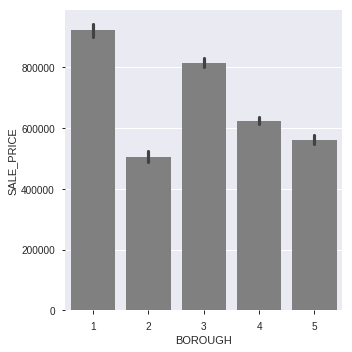

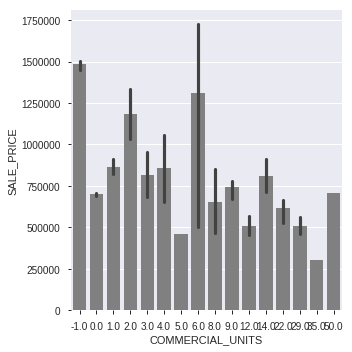

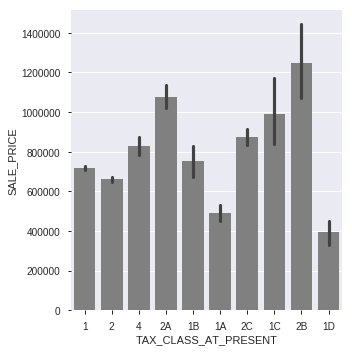

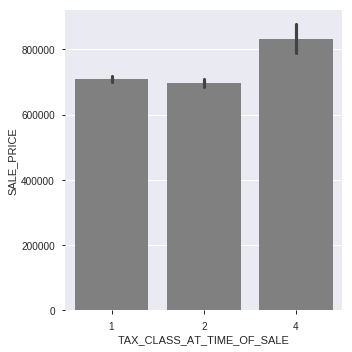

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in sorted(train.columns):
  if train[col].nunique() < 17:
    sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
    plt.show();

### Seaborn linear model plots for numeric features

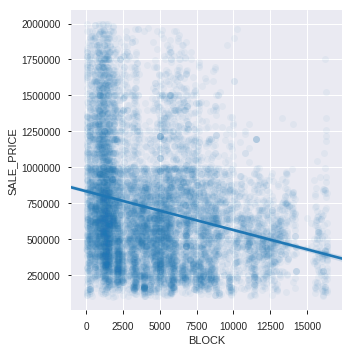

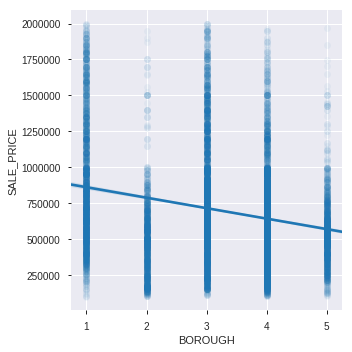

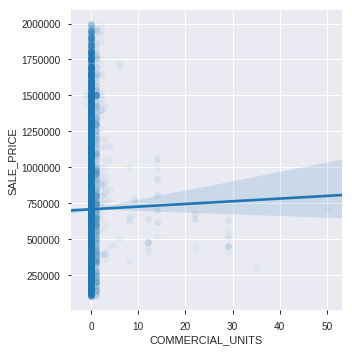

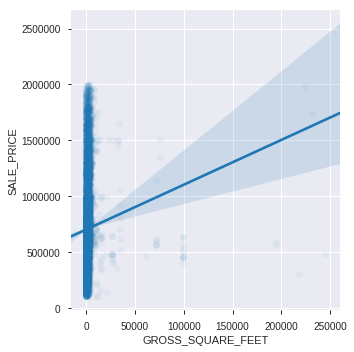

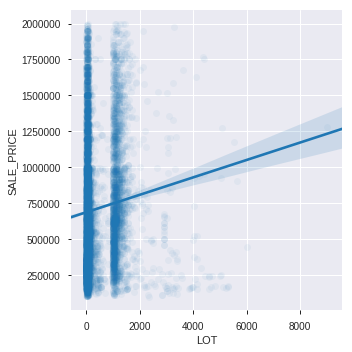

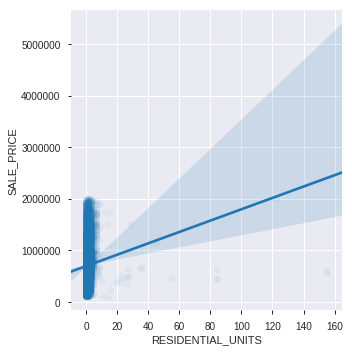

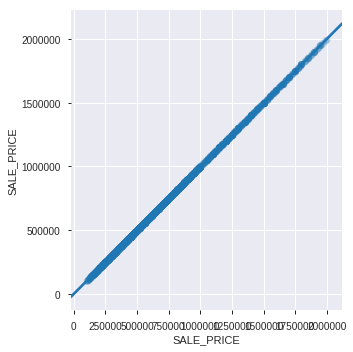

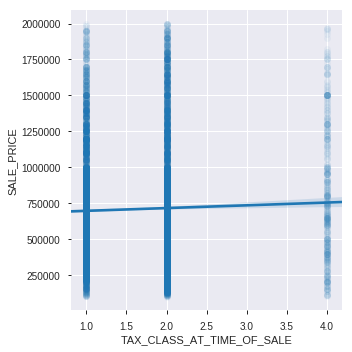

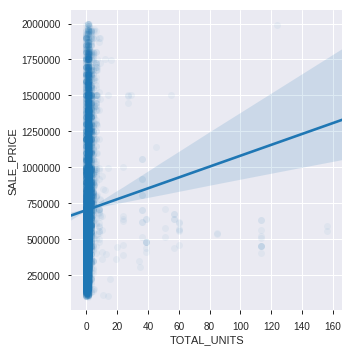

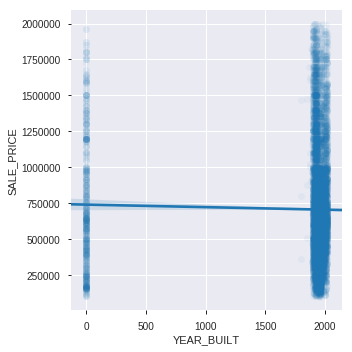

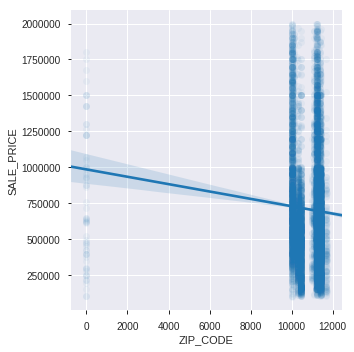

In [0]:
numeric = train.select_dtypes('number')

for col in sorted(numeric.columns):
  sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
  plt.show()

## Do one-hot encoding of categorical features.



which features are non-numeric?

In [0]:
train.describe()


,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,"10,442.0","10,442.0","10,442.0","10,442.0","10,442.0","10,442.0","10,442.0","10,442.0","10,437.0","10,442.0","10,442.0"
mean,3.1048649683968588,"4,638.203888144034",336.6080252825129,"10,820.642884504885",1.1603141160697183,0.13733001340739323,1.486784140969163,"1,595.9528825895422","1,839.8002299511354",1.571154951158782,"707,973.8431334994"
std,1.255585084636136,"3,704.4722149109175",595.6090619230946,"1,010.9903282710051",3.2022408913664564,1.3630738726207465,5.338074232437219,"6,643.725187750527",454.33266534668024,0.6948875293246827,"402,006.34780006914"
min,1.0,3.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,"100,044.0"
25%,2.0,"1,459.25",20.0,"10,310.0",0.0,0.0,0.0,0.0,"1,924.0",1.0,"410,000.0"
50%,3.0,"3,900.5",48.0,"11,211.0",1.0,0.0,1.0,"1,134.0","1,945.0",1.0,"625,000.0"
75%,4.0,"6,793.75",272.0,"11,364.0",2.0,0.0,2.0,"1,864.0","1,965.0",2.0,"900,000.0"
max,5.0,"16,350.0","9,002.0","11,697.0",155.0,50.0,156.0,"244,619.0","2,018.0",4.0,"1,999,877.0"


### Borough

Borough should be a categorical variable but it is coded as an integer. 

In [92]:
train.BOROUGH.value_counts()

4    3608
3    2774
1    1840
5    1129
2    1091
Name: BOROUGH, dtype: int64

In [91]:
train.BOROUGH.dtype

dtype('O')

In [0]:
# recode as string

train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

check the cardinality of non-numeric features i.e. number of unique values

In [93]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BOROUGH,10442,5,4,3608,NaN,NaN
TAX_CLASS_AT_PRESENT,10442,10,1,4949,NaN,NaN
BUILDING_CLASS_CATEGORY,10442,40,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
SALE_DATE,10442,80,2019-01-31 00:00:00,285,2019-01-01 00:00:00,2019-03-30 00:00:00
BUILDING_CLASS_AT_PRESENT,10442,96,D4,2110,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,10442,96,D4,2110,NaN,NaN
NEIGHBORHOOD,10442,245,FLUSHING-NORTH,307,NaN,NaN
APARTMENT_NUMBER,2136,826,2A,42,NaN,NaN
LAND_SQUARE_FEET,10417,1993,0,4061,NaN,NaN
ADDRESS,10442,10397,N/A BAY STREET,4,NaN,NaN


explore the BOROUGH feature

In [94]:
train.BOROUGH.value_counts(normalize=True)

4    0.3455276766902892
3    0.2656579199387091
1    0.1762114537444934
5   0.10812104960735491
2   0.10448190001915342
Name: BOROUGH, dtype: float64

In [95]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1   921,579.6255434783
2   505,663.6003666361
3   814,740.5922855083
4   623,981.2067627495
5   561,437.3551815766
Name: SALE_PRICE, dtype: float64

In [124]:
train.BOROUGH.head()

44    three
61     four
66      one
67      one
71      one
Name: BOROUGH, dtype: object

ecode Borough feature

In [123]:
train['BOROUGH'] = train['BOROUGH'].replace({'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

encoded = encoder.fit_transform(train['BOROUGH'])

encoded.head()

,BOROUGH_three,BOROUGH_four,BOROUGH_one,BOROUGH_two,BOROUGH_five
44,1,0,0,0,0
61,0,1,0,0,0
66,0,0,1,0,0
67,0,0,1,0,0
71,0,0,1,0,0


### neighbourhood

In [112]:
# there are 245 different neigborhoods
train['NEIGHBORHOOD'].value_counts().sum

<bound method Series.sum of OTHER                      8670
FLUSHING-NORTH              307
UPPER EAST SIDE (79-96)     188
UPPER EAST SIDE (59-79)     185
BEDFORD STUYVESANT          181
FOREST HILLS                179
JACKSON HEIGHTS             162
BAYSIDE                     147
FLUSHING-SOUTH              144
EAST NEW YORK               140
UPPER WEST SIDE (59-79)     139
Name: NEIGHBORHOOD, dtype: int64>

In [0]:
train.NEIGHBORHOOD.value_counts(normalize=True)

In [110]:
# we need to reduce cardinality from 245 to 10

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


encode Neighborhood

In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

encoded = encoder.fit_transform(train['NEIGHBORHOOD'])

encoded.head()

## one hot encoding & scale features

We scale features before fitting linear models to standardize datasets if features do not roughly look like standard normal distributions.

sklearn.preprocessing provides standardScalara that implements the Transformer API to compute the mean and standard dev of a training set. The scaler instance is then used on new test data to transform it the same way.

Scaled data has zero mean and unit variance.


How to use encoders and scalers?
- use the fit_transform method on the train set
- use the transform method on the test set

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
train.describe(exclude='number').T.sort_values(by='unique')

In [139]:
high_cardinal = ['BUILDING_CLASS_CATEGORY', 'BUILDING_CLASS_AT_PRESENT', 
                 'BUILDING_CLASS_AT_TIME_OF_SALE', 'APARTMENT_NUMBER',
                  'LAND_SQUARE_FEET', 'ADDRESS', 'SALE_DATE']

target = 'SALE_PRICE'

features = train.columns.drop([target] + high_cardinal)
# this removes all the high cardinality features from the training set

features

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [0]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [0]:
# use fit_transform on train set, transform on test set

# encode first
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# then scale 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.fit_transform(X_test_encoded)


In [148]:
# this passes through all the columns

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features


ValueError: ignored

## Do feature selection with SelectKBest
Today we are trying scikit-learn's SelectKBest transformer, for "univariate, forward selection."


We just want numeric columns with no missing values. So we have to get a subset of columns.

In [0]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')

assert all(train_subset.columns == test_subset.columns)

In [128]:
target = 'SALE_PRICE'

features = train_subset.columns.drop(target)

X_train = train_subset[features]
y_train = train_subset[target]

X_test = test_subset[features]
y_test = test_subset[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


# there are 8 features!

((10442, 8), (10442,), (2969, 8), (2969,))

Univariate, forward selection

In [0]:
# pick the 10 features that best correlate with the target

from sklearn.feature_selection import f_regression, SelectKBest

# model
selector = SelectKBest(score_func=f_regression, k=5)

In [130]:
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((10442, 5), (2969, 5))

which features were selected?

In [0]:
# setting up array
all_names = X_train.columns

# create mask
selected_mask = selector.get_support()

# apply the mask
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

In [132]:
print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
GROSS_SQUARE_FEET

Features not selected:
COMMERCIAL_UNITS
TOTAL_UNITS
TAX_CLASS_AT_TIME_OF_SALE


setting up regression model

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mae = mean_absolute_error(y_test, y_pred)

print(f'Test MAE: ${mae:,.0f}')

Test MAE: $309,463
